## Imports

In [1]:
import jupyter_black

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [2]:
# Import custom modules

import dataset
import helper_plots as hplt
import helper_train as htrain

from models.vae_old import ConvolutionalVAE

## Settings

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 111
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
BATCH_SIZE = 128
IMAGE_SIZE = 64
LATENT_SIZE = 4
RECONSTRUCTION_TERM_WEIGHT = 1

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Dataset

In [5]:
# Directory with source data

cells_dir = "/usr/src/data/separated_bacterias"
samples_dir = "/usr/src/samples"

transform = transforms.Compose(
    [transforms.ToPILImage(), dataset.CellPadResize(IMAGE_SIZE), transforms.ToTensor()]
)

cell_dataset = dataset.ImageDataset(cells_dir, "cell", transform=transform)
train_loader = DataLoader(cell_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Checking the dataset

print(f"Len of dataset:  {len(cell_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
for images in train_loader:
    print("Image batch dimensions:", images.size())
    break

Len of dataset:  1910 images
Len of trainloader:  15 batches
Image batch dimensions: torch.Size([128, 1, 64, 64])


## Convolutional VAE

In [7]:
set_all_seeds(RANDOM_SEED)

In [8]:
# Initialize model and optimizer

conv_vae = ConvolutionalVAE(DEVICE, IMAGE_SIZE, LATENT_SIZE)
conv_vae.to(DEVICE)

optimizer = torch.optim.Adam(conv_vae.parameters(), lr=LEARNING_RATE)

In [9]:
# Training

log_dict = htrain.train(
    NUM_EPOCHS, conv_vae, optimizer, DEVICE, train_loader, logging_interval=6
)

Epoch: 001/200 | Batch 0000/0015 | Loss: 1022.7473
Epoch: 001/200 | Batch 0006/0015 | Loss: 595.9514
Epoch: 001/200 | Batch 0012/0015 | Loss: 312.7300
Time elapsed: 0.03 min
Epoch: 002/200 | Batch 0000/0015 | Loss: 348.3311
Epoch: 002/200 | Batch 0006/0015 | Loss: 256.6093
Epoch: 002/200 | Batch 0012/0015 | Loss: 270.7715
Time elapsed: 0.04 min
Epoch: 003/200 | Batch 0000/0015 | Loss: 264.1533
Epoch: 003/200 | Batch 0006/0015 | Loss: 246.3673
Epoch: 003/200 | Batch 0012/0015 | Loss: 260.1366
Time elapsed: 0.05 min
Epoch: 004/200 | Batch 0000/0015 | Loss: 247.7481
Epoch: 004/200 | Batch 0006/0015 | Loss: 278.8029
Epoch: 004/200 | Batch 0012/0015 | Loss: 221.5246
Time elapsed: 0.06 min
Epoch: 005/200 | Batch 0000/0015 | Loss: 242.3356
Epoch: 005/200 | Batch 0006/0015 | Loss: 196.0166
Epoch: 005/200 | Batch 0012/0015 | Loss: 197.1879
Time elapsed: 0.07 min
Epoch: 006/200 | Batch 0000/0015 | Loss: 211.3085
Epoch: 006/200 | Batch 0006/0015 | Loss: 184.9348
Epoch: 006/200 | Batch 0012/0015 |

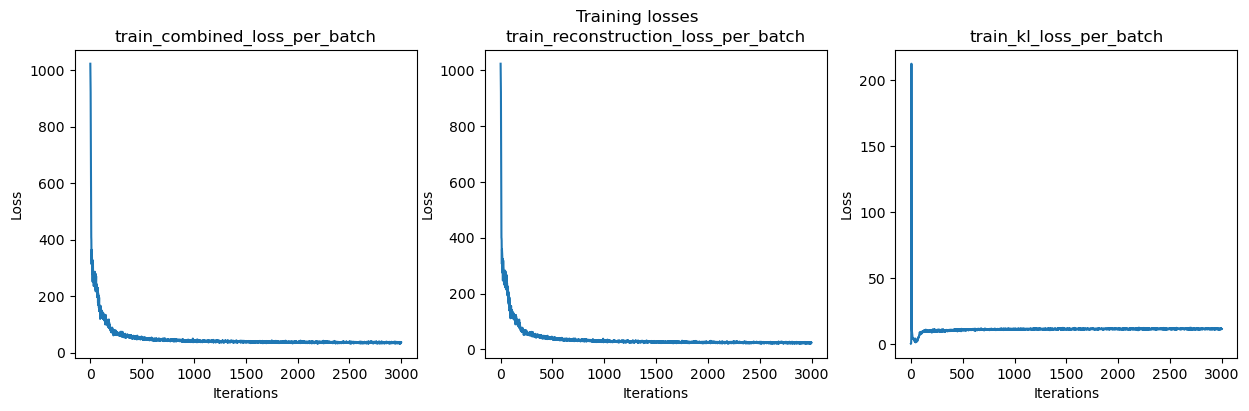

In [10]:
hplt.plot_all_losses(log_dict)

In [23]:
# Save trained model

torch.save(conv_vae, f"conv_vae_{LATENT_SIZE}_latent_{NUM_EPOCHS}_epochs.pt")

In [8]:
# Load pretrained model

conv_vae = torch.load("conv_vae_4_latent_200_epochs.pt")
conv_vae.eval()

ConvolutionalVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=4096, out_features=4, bias=True)
  (z_log_var): Linear(in_features=4096, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=4096, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTran

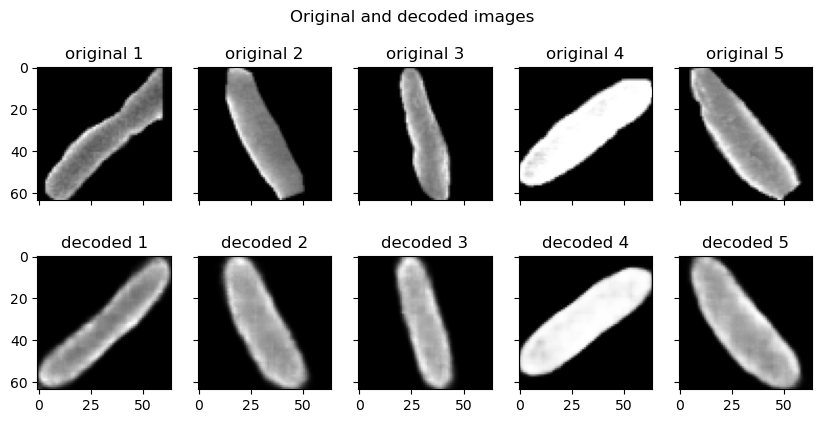

In [10]:
# Work VAE on training images

hplt.plot_original_and_decoded(conv_vae, train_loader, 5, DEVICE)

## Generating new images

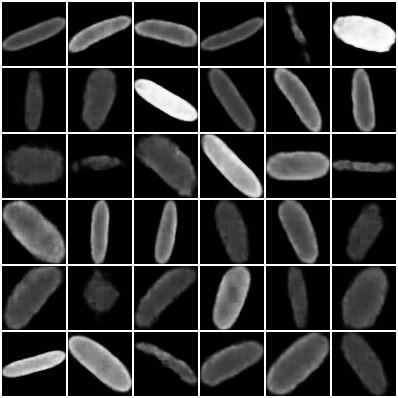

In [36]:
# Create grid of generated samples and show it

generated_images = hplt.show_grid_samples(conv_vae, 36, "generated_cells")

In [ ]:
# Generate many new separate samples and save them

hplt.generate_and_save_samples(samples_dir, 20, 20, conv_vae, IMAGE_SIZE)

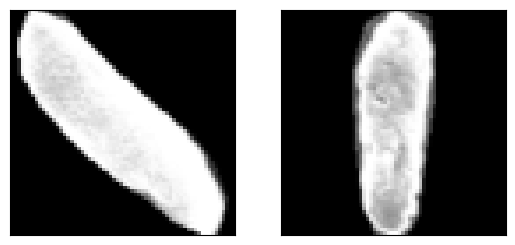

In [34]:
# 2 images from dataloader for creating interpolation

x = next(iter(train_loader))[:2]
hplt.show_images_bar(x)

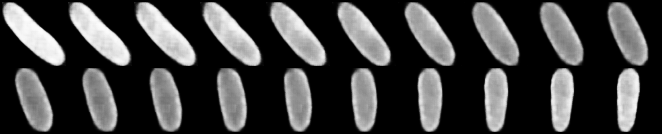

In [35]:
# Interpolation

x1, x2 = x
interp_list = hplt.interpolation(conv_vae, x1, x2, 20)
hplt.show_interpolation(interp_list, 10, "interpolation")